# kNN regression

Creates a k-d tree from the DNS data, enabling you to predict C_my by taking the average of the closest datapoints.

Then the estimated C_my is compared to the actual C_my to see how well the k-d tree works.

In [423]:
# Libraries:

# Data manipulation
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split
import pickle
from generate_dataset import dat_2_dataset

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm

# Calculations
from gradients import compute_face_phi, dphidx, dphidy, init
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance
from scipy.spatial import KDTree, cKDTree
import random

# Others
import time
import sys
import warnings
import matplotlib.cbook

### Read & manipulate DNS data

Choose case among   
small_wave/     
large_wave/     
one_hill/   
two_hills/

In [424]:
DNS_file_path = "large_wave/"
training_case = True

In [425]:
# Load data from tec and mesh files
tec = np.genfromtxt(DNS_file_path + "tec.dat", dtype=None, comments="%")
cell_faces = np.loadtxt(DNS_file_path + "mesh.dat")

In [426]:
# Assign parameters
x_center = tec[:, 0]
y_center = tec[:, 1] 
pressure = tec[:, 2]
x_velocity = tec[:, 3]
y_velocity = tec[:, 4]
x_stress = tec[:, 5]  # stress tensor normal to x
y_stress = tec[:, 6]  # stress tensor normal to y
z_stress = tec[:, 7]  # stress tensor normal to z
xy_stress = tec[:, 8]  # stress tensor normal to x & y
kinetic_energy = 0.5 * (x_stress + y_stress + z_stress)  # Turbulent kinetic energy
epsilon = tec[:, 9]  # Dissipation rate

In [427]:
# Define nxm matrix dimensions
if max(y_center) == 1.:
    n = 194
    m = 170
    viscosity = 1. / 10000.
else:
    viscosity = 1. / 10595.
    if max(x_center) > 8.:
        n = 162
        m = 162
    else:
        n = 162
        m = 402

In [428]:
# Function that takes many arrays and reshapes them to nxm matrices
def reshape(*args, n, m):
    return [np.reshape(arg, (n, m)) for arg in args]

In [429]:
def transpose(*args):
    return [np.transpose(arg) for arg in args]

In [430]:
# Reshape & transpose all arrays
x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = reshape(x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, n=n, m=m)
x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = transpose(x_center, y_center, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon)

In [431]:
# Set boundary conditions

# Set Neumann boundary conditions of p at upper and lower boundaries
pressure[:, 1] = pressure[:, 2]
pressure[:, -1] = pressure[:, -1 - 1]

# Set periodic b.c on west boundary so that the east & west boundaries are connected
x_velocity[0, :] = x_velocity[-1, :]
y_velocity[0, :] = y_velocity[-1, :]
pressure[0, :] = pressure[-1, :]
x_stress[0, :] = x_stress[-1, :]

In [432]:
# Assign cell faces from data file xc_yc.dat
# They are needed for the dphidx_dy routine

x_face = cell_faces[:, 0]
y_face = cell_faces[:, 1]
x_face = np.reshape(x_face, (n - 1, m - 1))
y_face = np.reshape(y_face, (n - 1, m - 1))
x_face = np.transpose(x_face)
y_face = np.transpose(y_face)

In [433]:
# Compute new cell centers
x_center_average = 0.25 * (x_center[0:-1, 0:-1] + x_center[0:-1, 1:] + x_center[1:, 0:-1] + x_center[1:, 1:])
y_center_average = 0.25 * (y_center[0:-1, 0:-1] + y_center[0:-1, 1:] + y_center[1:, 0:-1] + y_center[1:, 1:])

In [434]:
def delete_rows(*args, rows):
    return [np.delete(arg, rows, axis=0) for arg in args]

In [435]:
def delete_columns(*args, columns):
    return [np.delete(arg, columns, axis=1) for arg in args]

In [436]:
# Delete the last row & column of every parameter
x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_rows(x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, rows=-1)
x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_columns(x_center, y_center, x_center_average, y_center_average, pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, columns=-1)

In [437]:
# Delete the first row & column of every parameter except x_center & y_center
pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_rows(pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, rows=0)
pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon = delete_columns(pressure, x_velocity, y_velocity, x_stress, y_stress, z_stress, xy_stress, kinetic_energy, epsilon, columns=0)

In [438]:
# Compute geometric quantities
areaw, areawx, areawy, areas, areasx, areasy, vol, fx, fy = init(x_center, y_center, x_center_average, y_center_average)

In [439]:
# Adjust matrix dimensions
n = n - 2 
m = m - 2

In [440]:
# Adjust epsilon at last cell upper cell
epsilon[:, -1] = epsilon[:, -2]

In [441]:
# Compute face value of U and V
x_velocity_west, x_velocity_south = compute_face_phi(x_velocity, fx, fy, m, n)
y_velocity_west, y_velocity_south = compute_face_phi(y_velocity, fx, fy, m, n)

# x derivatives
dudx = dphidx(x_velocity_west, x_velocity_south, areawx, areasx, vol)
dvdx = dphidx(y_velocity_west, y_velocity_south, areawx, areasx, vol)

# y derivatives
dudy = dphidy(x_velocity_west, x_velocity_south, areawy, areasy, vol)
dvdy = dphidy(y_velocity_west, y_velocity_south, areawy, areasy, vol)

In [442]:
# Calculate correct C_my for prediction
omega = epsilon / kinetic_energy / 0.09
c_my = np.array(-xy_stress / (kinetic_energy * (dudy + dvdx)) * omega)

In [443]:
# Adjust the extreme values of C_my
c_my = np.ma.masked_where(c_my > 3, c_my)
c_my = np.ma.masked_where(c_my < 0, c_my)

(168, 192)


/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_17279/1504016809.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


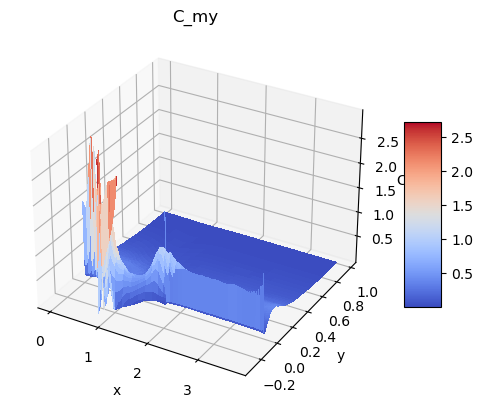

In [444]:
# Plot C_my to check if it looks correct
print(c_my.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
ax.set_title('C_my')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [445]:
# Function for calculating the sum of the distance between a point and its k nearest neighbors
def sum_of_distances(node, k):
    distance, index = c_my_tree.query(node, k=k)
    return np.sum(distance)

In [446]:
# Function for finding the radius of the k nearest neighbors
def radius_of_knn(node, k):
    distance, index = c_my_tree.query(node, k=k)
    return distance[-1]

In [447]:
# Reshape dudy and dvdx into a 2D array

dudy = np.reshape(dudy, (n * m, 1))
dvdx = np.reshape(dvdx, (n * m, 1))

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_17279/2458516636.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


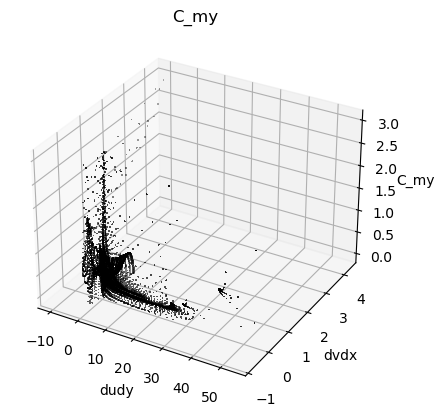

In [448]:
# Plot c_my over the dudy and dvdx plane

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.scatter(dudy, dvdx, c_my, linewidth=0, antialiased=False, s=1, marker='.', c='k', edgecolors='none', vmin=0, vmax=3, zorder=1)
ax.set_xlabel('dudy')
ax.set_ylabel('dvdx')
ax.set_zlabel('C_my')
ax.set_title('C_my')
plt.show()

In [449]:
# Read all data files

tec_SW  = "small_wave/tec.dat"
mesh_SW = "small_wave/mesh.dat"
tec_LW  = "large_wave/tec.dat"
mesh_LW = "large_wave/mesh.dat"
tec_OH  = "one_hill/tec.dat"
mesh_OH = "one_hill/mesh.dat"
tec_TH  = "two_hills/tec.dat"
mesh_TH = "two_hills/mesh.dat"

In [450]:
# numpy arrays for all DNS data

dudx_SW, dvdx_SW, dudy_SW, dvdy_SW, cmy_SW, duidxj_SW, x_SW, y_SW, p_SW, u_SW, v_SW, uu_SW, vv_SW, ww_SW, uv_SW, eps_SW, k_SW = dat_2_dataset(tec_SW, mesh_SW,False)
dudx_LW, dvdx_LW, dudy_LW, dvdy_LW, cmy_LW, duidxj_LW, x_LW, y_LW, p_LW, u_LW, v_LW, uu_LW, vv_LW, ww_LW, uv_LW, eps_LW, k_LW = dat_2_dataset(tec_LW, mesh_LW,False)

In [451]:
# Training & test data

# training_points = dudx_SW, dvdx_SW, dudy_SW, dvdy_SW, duidxj_SW
# training_c_my = cmy_SW
# test_points = dudx_LW, dvdx_LW, dudy_LW, dvdy_LW, duidxj_LW
# test_c_my = cmy_LW

# Transform the training data into numpy arrays
# training_points = np.concatenate(training_points, axis=1)
# training_c_my = np.reshape(training_c_my, (n * m, 1))
# test_points = np.concatenate(test_points, axis=1)
# test_c_my = np.reshape(test_c_my, (n * m, 1))

training_points = np.concatenate((dudy, dvdx), axis=1)
training_c_my = np.reshape(c_my, (n * m, 1))
test_points = np.concatenate((dudy, dvdx), axis=1)
test_c_my = np.reshape(c_my, (n * m, 1))

#else:
#    training_percentage = 0.8
#
#    points = np.concatenate((dudy, dvdx), axis=1)
#    c_my_list = np.reshape(c_my, (n * m, 1))
#    points_and_c_my = np.concatenate((points, c_my_list), axis=1)
#
#    np.random.shuffle(points_and_c_my) 
#
#    training_data = points_and_c_my[:int(len(points_and_c_my) * training_percentage)]
#    training_points = training_data[:, :2]
#    training_c_my = training_data[:, 2]
#
#    test_points = np.delete(points, np.s_[0:int(len(points) * training_percentage)], axis=0)
#    test_c_my = np.delete(c_my_list, np.s_[0:int(len(c_my_list) * training_percentage)], axis=0)

In [452]:
# Create or load KDTree

if training_case:
    c_my_tree = cKDTree(training_points)
    with open('c_my_tree.pickle', 'wb') as f:
        pickle.dump(c_my_tree, f)
else:
    with open('c_my_tree.pickle', 'rb') as f:
        c_my_tree = pickle.load(f)

In [453]:
# kNN regression for C_my with k = 10

# Create a list of the k nearest neighbors for each point
k = 10
knn = c_my_tree.query(test_points, k=k)

# Information about the k nearest neighbors
distances = knn[0] # Distances between each point and its k nearest neighbors
indices = knn[1]
knn_c_my = training_c_my[indices] # C_my values of the k nearest neighbors for each point
print(knn_c_my.shape)
print(indices.shape)
print(training_c_my.shape)
average_knn_c_my = np.mean(knn_c_my, axis=1)
std_knn_c_my = np.std(knn_c_my, axis=1) # Standard deviation

# Ignore the points that have a standard deviation greater than 0.5
std_threshold = 0.5
average_knn_c_my = np.ma.masked_where(std_knn_c_my > std_threshold, average_knn_c_my)

(32256, 10, 1)
(32256, 10)
(32256, 1)


In [454]:
mean_absolute_error = np.mean(np.abs(average_knn_c_my - test_c_my))
print('Mean absolute error: ' + str(mean_absolute_error))

Mean absolute error: 0.0673326772373915


In [455]:
mean_squared_error = np.mean((average_knn_c_my - test_c_my) ** 2)
root_mean_squared_error = np.sqrt(mean_squared_error)
print('Mean squared error: ' + str(mean_squared_error))
print('Root mean squared error: ' + str(root_mean_squared_error))

Mean squared error: 0.015274931787346657
Root mean squared error: 0.12359179498391734


In [456]:
Lars_error = np.std(average_knn_c_my - test_c_my) / np.mean(average_knn_c_my**2)**0.5
print('Lars error: ' + str(Lars_error))

Lars error: 0.30457190801421846


In [457]:
mean_absolute_percentage_error = np.mean(np.abs((average_knn_c_my - test_c_my) / test_c_my)) * 100
print('Mean absolute percentage error: ' + str(mean_absolute_percentage_error), '%')

Mean absolute percentage error: 41.257278309765425 %


/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_17279/3646632638.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


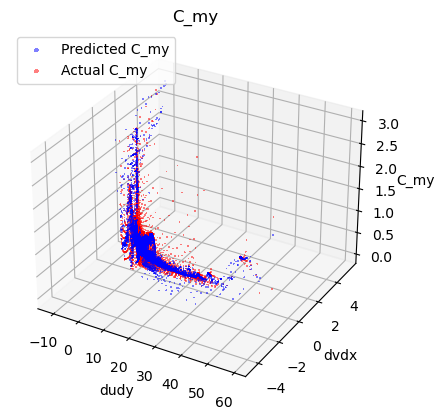

In [458]:
# Plot the predicted & actual C_my values

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.scatter(test_points[:, 0], test_points[:, 1], average_knn_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, s=1, alpha=0.5, marker='.', c='b', edgecolors='none', vmin=0, vmax=3, zorder=1)
ax.scatter(test_points[:, 0], test_points[:, 1], test_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, s=1, alpha=0.5, marker='.', c='r', edgecolors='none', vmin=0, vmax=3, zorder=1)
ax.set_xlabel('dudy')
ax.set_ylabel('dvdx')
ax.set_zlabel('C_my')
ax.set_title('C_my')
plt.legend(['Predicted C_my', 'Actual C_my'], numpoints=1, loc='upper left', prop={'size': 10}, markerscale=5)
plt.show()

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_17279/146046132.py:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


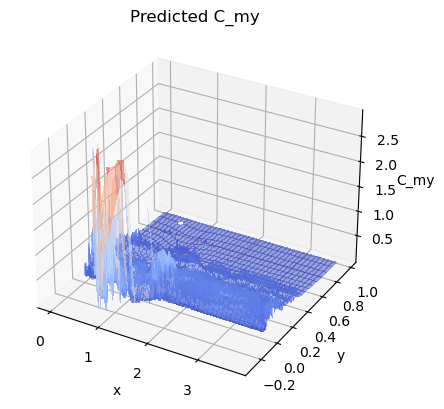

/var/folders/19/k6d12h6s6hng1s70_0wscmh80000gn/T/ipykernel_17279/146046132.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


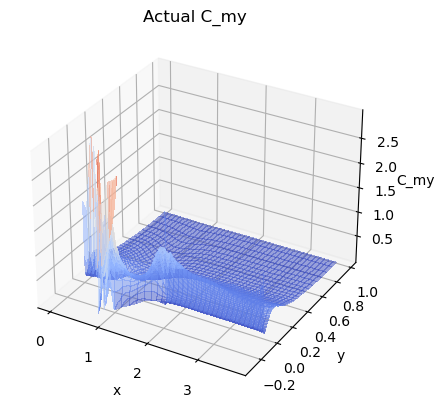

In [459]:
# Plot the predicted & actual C_my values over the x_center and y_center plane in subplots

# Reshape the data to earlier dimensions
average_knn_c_my = np.reshape(average_knn_c_my, (m, n))
test_c_my = np.reshape(test_c_my, (m, n))

# Plot the predicted & actual C_my values over the x_center_average and y_center_average plane

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, average_knn_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5, vmin=0, vmax=3, zorder=1)
ax.set_title('Predicted C_my')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_center_average, y_center_average, test_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5, vmin=0, vmax=3, zorder=1)
ax.set_title('Actual C_my')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('C_my')
plt.show()

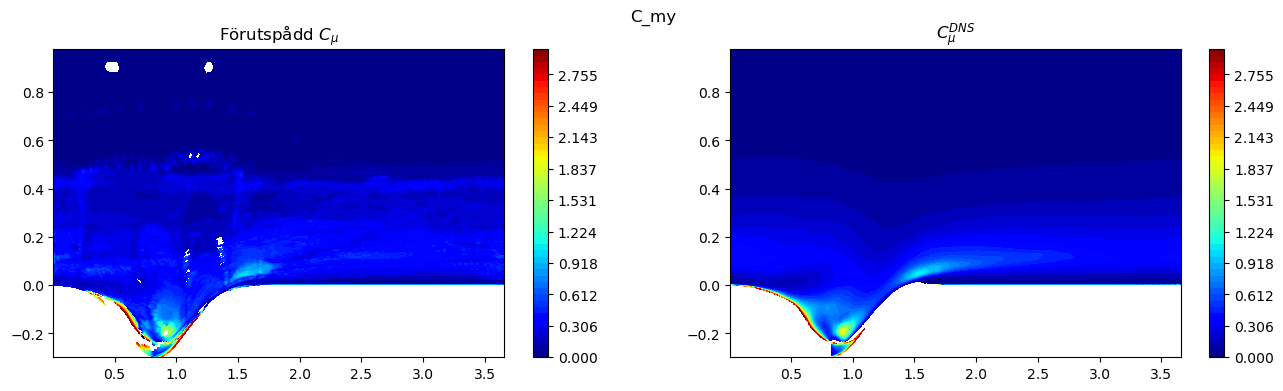

In [460]:
# Plot the predicted & actual C_my values over the x_center_average and y_center_average plane in heatmaps

# Reshape the data to earlier dimensions
average_knn_c_my = np.reshape(average_knn_c_my, (m, n))
test_c_my = np.reshape(test_c_my, (m, n))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
fig.suptitle('C_my')

jet = plt.get_cmap('jet')
cmu_range = np.linspace(0,3,50)

cmu_pred = ax1.contourf(x_center_average,y_center_average,average_knn_c_my,levels=cmu_range,cmap= jet)
cmu      = ax2.contourf(x_center_average,y_center_average,test_c_my,levels=cmu_range,cmap= jet)

fig.colorbar(cmu_pred,ax=ax1)
fig.colorbar(cmu,ax=ax2)

ax1.set_title('Förutspådd $C_{\mu}$')
ax2.set_title('$C_{\mu}^{DNS}$')

plt.show()

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(x_center_average, y_center_average, average_knn_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5, vmin=0, vmax=3, zorder=1)
# ax.set_title('Predicted C_my')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('C_my')
# plt.show()

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# surf = ax.plot_surface(x_center_average, y_center_average, test_c_my, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.5, vmin=0, vmax=3, zorder=1)
# ax.set_title('Actual C_my')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('C_my')
# plt.show()
